<br><br>

<img src="https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/melt.png" width="100%" style="margin-left:auto; margin-right:auto">


<br>

# Homework3: `pandas` DataFrame manipulations

## Part 1: `pandas` Melting and Pivoting

In this first section we will melt and pivot a pandas dataframe. A smart combination of manipulating and aggregating the dataframe will help us extract different insights without having to write messy for loops. We will use a simple toy dataset to illustrate each data restructuring method.  

First, let's define a few terms:  

* **Aggregating** - Condensing the data by grouping like observations and producing summary metrics to characterize the new grouping. Aggregated data will typically have a smaller sized dataframe as a result.
* **Wide Data** - each row holds more than one observations for a given value of index feature(s)
* **Long Data** - each row holds one observation 
* **Melting** - Restructuring the data from a 'wide' to a 'long' format. The data is reshaped so that each row holds only one observation for a particular category. Also called 'pivoting long'.
* **Pivoting** - Restructuring the data from a 'long' to a 'wide' format. The data is reshape typically into categorical columns. Also called 'pivoting wide'.

Now to import the data

In [1]:
# Let's set up with these libraries handy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing our tiny toy data set as a pandas dataframe
url = 'https://raw.githubusercontent.com/SmilodonCub/DS4VS/master/Homework/flights.csv'
col_names = ['Carrier', 'Status', 'LAX', 'PHX', 'SAN', 'SFO', 'SEA']
flights = pd.read_csv( url, encoding= 'unicode_escape' )
flights.columns = col_names
flights = flights.ffill() #will fill in missing values (default along column axis)

print( flights.shape )
flights

(4, 7)


,Carrier,Status,LAX,PHX,SAN,SFO,SEA
0,ALASKA,on time,497,221,212,503,1841
1,ALASKA,delayed,62,12,20,102,305
2,AM West,on time,694,4840,383,320,201
3,AM West,delayed,117,415,65,129,61



### Morphing Shapes...

Currently, the `flights` dataframe is organized in a wide format. Observe how each row holds multiple observations for a single condition. For example, `flights.iloc[0]` holds observations summarizing the number of 'on time' 'ALASKA' flights for 'LAX', 'PHX', 'SAN', 'SFO' and 'SEA'.  

For such a small dataset, this format makes for a very easy to understand summary of the data to human eyes, but it it is not very convenient for analysis. For example, what if we would like to compare the proportion of flights that are on-time vs delayed for each airport and carrier. This would be complicated with the wide format!  

Let's melt the dataframe into the long format:  

In [3]:
# use the pd.melt() method to selectively melt the airport columns 
# while keeping the Carrier & Status as index columns

flights_long = pd.melt( flights, id_vars = ['Carrier', 'Status'], 
                       value_vars = ['LAX', 'PHX', 'SAN', 'SFO', 'SEA'], 
                       var_name = 'Airport', 
                       value_name='Total' )

flights_long

,Carrier,Status,Airport,Total
0,ALASKA,on time,LAX,497
1,ALASKA,delayed,LAX,62
2,AM West,on time,LAX,694
3,AM West,delayed,LAX,117
4,ALASKA,on time,PHX,221
5,ALASKA,delayed,PHX,12
6,AM West,on time,PHX,4840
7,AM West,delayed,PHX,415
8,ALASKA,on time,SAN,212
9,ALASKA,delayed,SAN,20


In [4]:
a=flights_long.pivot_table(index=['Carrier','Status'],columns=['Airport'],values='Total')
print(a)
a.index

Airport          LAX   PHX  SAN   SEA  SFO
Carrier Status                            
ALASKA  delayed   62    12   20   305  102
        on time  497   221  212  1841  503
AM West delayed  117   415   65    61  129
        on time  694  4840  383   201  320


MultiIndex([( 'ALASKA', 'delayed'),
            ( 'ALASKA', 'on time'),
            ('AM West', 'delayed'),
            ('AM West', 'on time')],
           names=['Carrier', 'Status'])

<br>

Great! we now have a looong flights dataframe.  
But, let's say we are interested in calculating the percent of on-time/delayed flights for each Carrier/Status condition. That would be hard to compute from this configuration of the dataframe. We'd have to work hard to find the total for each Carrier/Status by looping alternate rows and we'd need to create a new data structure to hold the results...sounds messy & unnecessary because it is. Let's just restructure the data in a way that gives us the 'on-time' and 'delayed' observations as new feature columns by pivoting the dataframe.  

We will now pivot flights_long with 'Carrier' and 'Airport' serving as our index columns while we widen the total into new columns for 'on-time' and 'delayed':  

In [5]:
flights_status = flights_long.pivot_table(index = ['Carrier','Airport'],columns = 'Status', values = 'Total')
flights_status

Status           delayed  on time
Carrier Airport                  
ALASKA  LAX           62      497
        PHX           12      221
        SAN           20      212
        SEA          305     1841
        SFO          102      503
AM West LAX          117      694
        PHX          415     4840
        SAN           65      383
        SEA           61      201
        SFO          129      320

In [6]:
flights_status.pivot_table(index=['Carrier'],columns='Airport',values='delayed')

Airport,LAX,PHX,SAN,SEA,SFO
Carrier,,,,,
ALASKA,62,12,20,305,102
AM West,117,415,65,61,129


<br>

The data is now somewhere inbetween long and wide, but just where we need it for our purposes.  
Now we can easily find the total flights by taking the sum of the 'delayed' + 'on-time' columns. It is also easy to then calculate the percentage for each observation....

In [7]:
flights_status['Total'] = flights_status['delayed'] + flights_status['on time']
flights_status['p_delayed'] = flights_status['delayed']/flights_status['Total']*100
flights_status['p_ontime'] = flights_status['on time']/flights_status['Total']*100
flights_status = flights_status.round( 2 )
flights_status = flights_status.reset_index()
flights_status

Status,Carrier,Airport,delayed,on time,Total,p_delayed,p_ontime
0,ALASKA,LAX,62,497,559,11.09,88.91
1,ALASKA,PHX,12,221,233,5.15,94.85
2,ALASKA,SAN,20,212,232,8.62,91.38
3,ALASKA,SEA,305,1841,2146,14.21,85.79
4,ALASKA,SFO,102,503,605,16.86,83.14
5,AM West,LAX,117,694,811,14.43,85.57
6,AM West,PHX,415,4840,5255,7.90,92.10
7,AM West,SAN,65,383,448,14.51,85.49
8,AM West,SEA,61,201,262,23.28,76.72
9,AM West,SFO,129,320,449,28.73,71.27


<br>

We can do a quick visualization of the data...

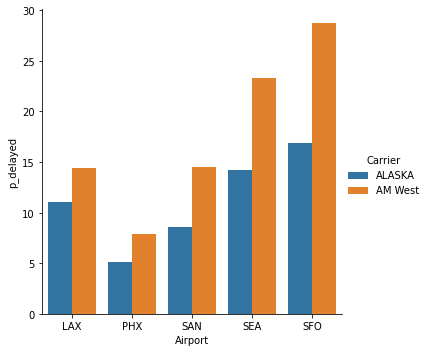

In [8]:
# visualize the percentage of delayed flights for the airlines for each destination
fig = sns.catplot( data = flights_status,
                  kind = 'bar',
                  x = 'Airport',
                  y = 'p_delayed',
                  hue = 'Carrier'
                 )

<br>

From the figure above we can see that AM West flights are more likely to be delayed at all given airports. 

Next we would like to answer a different question about the data: What are the total number of 'delayed' and 'on time' flights for each airline? This will require aggregating our data into groups for each airline: 

In [9]:
# aggregate the data to find the total number of flights for each airline
#    1) group on the column 'Carrier'
#    2) take the sum of the numeric columns
#    3) drop the 'p_' columns because they don't make sense as a summed value
flights_status.groupby( 'Carrier' ).sum( ).drop( columns=['p_delayed', 'p_ontime'])

Status,delayed,on time,Total
Carrier,,,
ALASKA,501,3274,3775
AM West,787,6438,7225


In [120]:
flights_status

Status,Carrier,Airport,delayed,on time,Total,p_delayed,p_ontime
0,ALASKA,LAX,62,497,559,11.09,88.91
1,ALASKA,PHX,12,221,233,5.15,94.85
2,ALASKA,SAN,20,212,232,8.62,91.38
3,ALASKA,SEA,305,1841,2146,14.21,85.79
4,ALASKA,SFO,102,503,605,16.86,83.14
5,AM West,LAX,117,694,811,14.43,85.57
6,AM West,PHX,415,4840,5255,7.90,92.10
7,AM West,SAN,65,383,448,14.51,85.49
8,AM West,SEA,61,201,262,23.28,76.72
9,AM West,SFO,129,320,449,28.73,71.27


<br>

### Now you try!

**Question 1** Using the `flights_status` dataframe, aggregate the data to get the total flights grouped by 'Airport'

In [10]:
flights_status.groupby('Airport').sum().drop(columns=['delayed','on time','p_delayed', 'p_ontime'])

Status,Total
Airport,
LAX,1370
PHX,5488
SAN,680
SEA,2408
SFO,1054


**Question 2** The original format of the dataframe was very friendly to human eyes, but the values are difficult to draw insights from. Can you reshape the `flights_status` dataframe back to the original (4, 7) using the new percentage values you computed above?

In [13]:
flights_p_delay=flights_status.pivot_table(index='Carrier',columns=['Airport'],values='p_delayed')
flights_p_delay['Status']='delay'
flights_p_ontime=flights_status.pivot_table(index='Carrier',columns=['Airport'],values='p_ontime')
flights_p_ontime['Status']='on time'
flights_status_new=pd.concat([flights_p_delay,flights_p_ontime])
flights_status_new

Airport,LAX,PHX,SAN,SEA,SFO,Status
Carrier,,,,,,
ALASKA,11.09,5.15,8.62,14.21,16.86,delay
AM West,14.43,7.90,14.51,23.28,28.73,delay
ALASKA,88.91,94.85,91.38,85.79,83.14,on time
AM West,85.57,92.10,85.49,76.72,71.27,on time


**Question 3** This figure above plots the percentage of delayed flights per destination for each carrier. We can think of these plotted values as the conditional probability, $\mbox{P}_{\mbox{Airport}}(\mbox{delayed}|\mbox{ALASKA})$. What if we are really interested in a different question: For a given 'Airport', what is the propability of flights for a given 'Carrier'

In [23]:
# I interpreted the question as "What is the probability of a certain carrier, given a certain airport"
flights_by_airport=flights_long.groupby(['Airport','Carrier']).sum()
flights_by_airport=flights_by_airport.pivot_table(index='Airport',columns='Carrier',values='Total')
flights_by_airport['Total']=flights_by_airport['ALASKA']+flights_by_airport['AM West']
flights_by_airport

Carrier,ALASKA,AM West,Total
Airport,,,
LAX,559,811,1370
PHX,233,5255,5488
SAN,232,448,680
SEA,2146,262,2408
SFO,605,449,1054


In [26]:
# Now I need to sum at each airport and devide each of them by the total to get probability 
flights_by_airport['P_ALASKA']=flights_by_airport['ALASKA']/flights_by_airport['Total']*100
flights_by_airport['P_AM West']=flights_by_airport['AM West']/flights_by_airport['Total']*100
flights_by_airport.drop(columns=['ALASKA','AM West','Total'])

Carrier,P_ALASKA,P_AM West
Airport,,
LAX,40.802920,59.197080
PHX,4.245627,95.754373
SAN,34.117647,65.882353
SEA,89.119601,10.880399
SFO,57.400380,42.599620


**Optional** We had already calculated the conditional probability (what is the probability that a flight is delayed given it is ALASKA|AM WEST). Question 3 finds the prior (what is the probabilty a flight to an Airport is ALASKA|AM WEST. Can you invert the conditional probability, $\mbox{P}_{\mbox{Airport}}(\mbox{ALASKA}|\mbox{delayed})$?

In [86]:
# We haven't computed P(status|Carrier) yet. We only have computed P(status|Carrier,Airport)
# First, I compute P(status|Carrier) and denote as p_sta_car
# aggregate over carrier and status (since we dont need the infor for the airport for this)
flights_sta_car=flights_long.groupby(['Carrier','Status'])['Total'].sum().reset_index()
# Make a table that is easy to see
flights_sta_car=flights_sta_car=flights_sta_car.pivot_table(index='Status',columns='Carrier')
flights_sta_car=flights_sta_car.set_axis(['ALASKA','AM West'],axis=1)
flights_sta_car=flights_sta_car.set_axis(['delayed','on time'],axis=0)
flights_sta_car

,ALASKA,AM West
delayed,501,787
on time,3274,6438


In [125]:
# I will compute the conditional probability of status given carrier
p_sta_car=flights_sta_car/flights_sta_car.sum()
p_sta_car

,ALASKA,AM West
delayed,0.132715,0.108927
on time,0.867285,0.891073


In [126]:
# I can also compute the conditional probability of the flight from certain carrier given the status (denote as p_car_sta)
flights_car_sta=flights_sta_car.T
p_car_sta=flights_car_sta/flights_car_sta.sum()
p_car_sta

,delayed,on time
ALASKA,0.388975,0.337109
AM West,0.611025,0.662891


In [137]:
#P(Carrier)=sum P(Carrier|Status)*P(Status) (over status)
# We also need to know P(Status) which is probability of the flight being delayed/on time (regardless of all the carriers and destinations)
# which is not available. So, I assume that probability of the status(delay or on time) based on this data
# will reflect overall probability of the status
flights_sta=flights_long.groupby('Status').sum()
p_status=flights_sta/flights_sta.sum()
p_status

,Total
Status,
delayed,0.117091
on time,0.882909


In [142]:
p_alaska=p_car_sta['delayed'].loc['ALASKA']*p_status.loc['delayed']+p_car_sta['on time'].loc['ALASKA']*p_status.loc['on time']
p_AMWest=p_car_sta['delayed'].loc['AM West']*p_status.loc['delayed']+p_car_sta['on time'].loc['AM West']*p_status.loc['on time']
p_carrier=pd.DataFrame({'ALASKA':p_alaska,'AM West':p_AMWest})
p_carrier

,ALASKA,AM West
Total,0.343182,0.656818


## Part 2: Working with your own data

Think back to Homework #2. Use the code we developed there as a framework to wrangle some data of your own into a pandas dataframe. **Bonus**: can you find an application for one of the dataframe manipulations reviewed in this homework assignment (aggregating, melting, pivoting)  

<br><br>

In [198]:
# convert mat file to dataframe
import numpy as np
import scipy.io as spio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def Ex_rolling(obnum):
    lib = spio.loadmat(f'/Volumes/GoogleDrive/My Drive/Akihito/Experiment_R_S_W/Results/ExRWSRigidObserver{obnum}.mat')
    result=lib['Stim_new']
    result_dic={'Stim_type': np.array([ii[0][0][:] for ii in result[0][0][1][:]]).reshape((540,)),'Size':result[0][0][2][:].reshape((540,)),'Speed':result[0][0][3][:].reshape((540,)),
                'Question':np.array([ii[0][0][:] for ii in result[0][0][4][:]]).reshape((540,)),
                'Response':result[0][0][5][:].reshape((540,))}
    
    questions=['Are the rings wobbling around each other without a fixed connection? (No: 4, Yes:6)','Are they rolling around each other? (No: 4, Yes:6)',
               'Are the rings rotating together while connected? (No: 4, Yes:6)'];
    for ii,xx in enumerate(result_dic['Question']):
        if xx==questions[0]:
            result_dic['Question'][ii]='Wobbling'
        elif xx==questions[1]:
            result_dic['Question'][ii]='Rolling'
        else:
            result_dic['Question'][ii]='Rotating'
    Size=['3 deg','6 deg'];
    Speed=['0.6 deg/sec','6.0 deg/sec','60.0 deg/sec'];
    result_dic['Size']=[Size[int(result_dic['Size'][ii])] for ii in range(540) ]
    result_dic['Speed']=[Speed[int(result_dic['Speed'][ii])] for ii in range(540) ]
    result_pd=pd.DataFrame(result_dic,index=np.arange(0,540,step=1))

    
    result_pd['Observer']=obnum
    return result_pd

# Convert data
def Ex_rigid_non_rigid(obnum):
    row_data = spio.loadmat(f'/Users/akihitomaruya/Desktop/Project/Project2021/Tire/Viewpixx3/Results/Ex3RigidOrNonRigidObserver{obnum}.mat')
    Results=row_data['Results']
    #% Results are (600,8), where each row corresponds to one trial and the columns are
    #[Response Size Speed stim_num response_time condition_num start_frame clock_wise_or_counter]
    
    # Assign the name of stimuli to the stimulus number 
    stim=['Circ ring','Circ w gap','Circ w paint','Oct on edge','Oct on vertex',
          'Circ wobble','Circ w gap wobble','Circ w paint wobble',
          'Oct on edge wobble','Oct on vertex wobble',
          'Rect on vertex','Rect on edge','Long ellipse','Wide ellipse'];
    
    Size=['3 deg','6 deg'];
    
    Speed=['0.6 deg/sec','6.0 deg/sec','60.0 deg/sec'];
    
    # Assign column name
    Key_name=['Response','Size','Speed','Type','Response time','Condition number','Start frame','Counter clockwise rotation']
    # Put them in dictionary 
    Results_dic={xx : Results[:,[ii]].reshape(len(Results),) for ii,xx in enumerate(Key_name)}
    Results_dic['Size']=[Size[int(Results_dic['Size'][ii])] for ii in range(len(Results)) ]
    Results_dic['Speed']=[Speed[int(Results_dic['Speed'][ii])] for ii in range(len(Results)) ]
    Results_dic['Type']=[stim[int(Results_dic['Type'][ii])-1] for ii in range(len(Results)) ]
    results_pd=pd.DataFrame(Results_dic,index=(np.arange(0,len(Results),step=1)))
    results_pd['Observer']=obnum
    return results_pd

In [200]:
#%% Ex1 Rigid and non-rigid experiment

result_all=[Ex_rigid_non_rigid(obnum+1) for obnum in range(10)]
Result_all=pd.concat(result_all)
Result_all.head()

,Response,Size,Speed,Type,Response time,Condition number,Start frame,Counter clockwise rotation,Observer
0,0.0,6 deg,6.0 deg/sec,Circ w gap,1.362,1.0,0.397222,-1.0,1
1,0.0,3 deg,6.0 deg/sec,Oct on vertex,0.893,1.0,0.347222,-1.0,1
2,0.0,3 deg,0.6 deg/sec,Wide ellipse,2.712,1.0,0.138889,1.0,1
3,0.0,3 deg,60.0 deg/sec,Rect on edge,10.924,1.0,0.383333,-1.0,1
4,0.0,6 deg,60.0 deg/sec,Rect on edge,3.654,1.0,0.177778,1.0,1


In [205]:
#%% Ex2 Rotation, wobbling, and rolling experiment
result_all2=[Ex_rolling(obnum+1) for obnum in range(10)]
Result_all2=pd.concat(result_all2)
Result_all2.head()

,Stim_type,Size,Speed,Question,Response,Observer
0,SW,6 deg,60.0 deg/sec,Wobbling,1,1
1,NR,6 deg,60.0 deg/sec,Wobbling,1,1
2,NW,6 deg,60.0 deg/sec,Wobbling,1,1
3,SS,3 deg,6.0 deg/sec,Wobbling,0,1
4,SW,6 deg,0.6 deg/sec,Wobbling,1,1


In [212]:
# Now I would like to compute the probability that people see 
# the cetrain stimuli as non-rigid by aggregating by its size, speed, and type the dataframe
Agg_result=Result_all.groupby(['Size','Speed','Type'])['Response'].mean().reset_index()
Agg_result

,Size,Speed,Type,Response
0,3 deg,0.6 deg/sec,Circ ring,0.18
1,3 deg,0.6 deg/sec,Circ w gap,0.01
2,3 deg,0.6 deg/sec,Circ w paint,0.01
3,3 deg,0.6 deg/sec,Circ wobble,0.15
4,3 deg,0.6 deg/sec,Long ellipse,0.07
5,3 deg,0.6 deg/sec,Oct on edge,0.00
6,3 deg,0.6 deg/sec,Oct on vertex,0.05
7,3 deg,0.6 deg/sec,Rect on edge,0.03
8,3 deg,0.6 deg/sec,Rect on vertex,0.00
9,3 deg,0.6 deg/sec,Wide ellipse,0.12


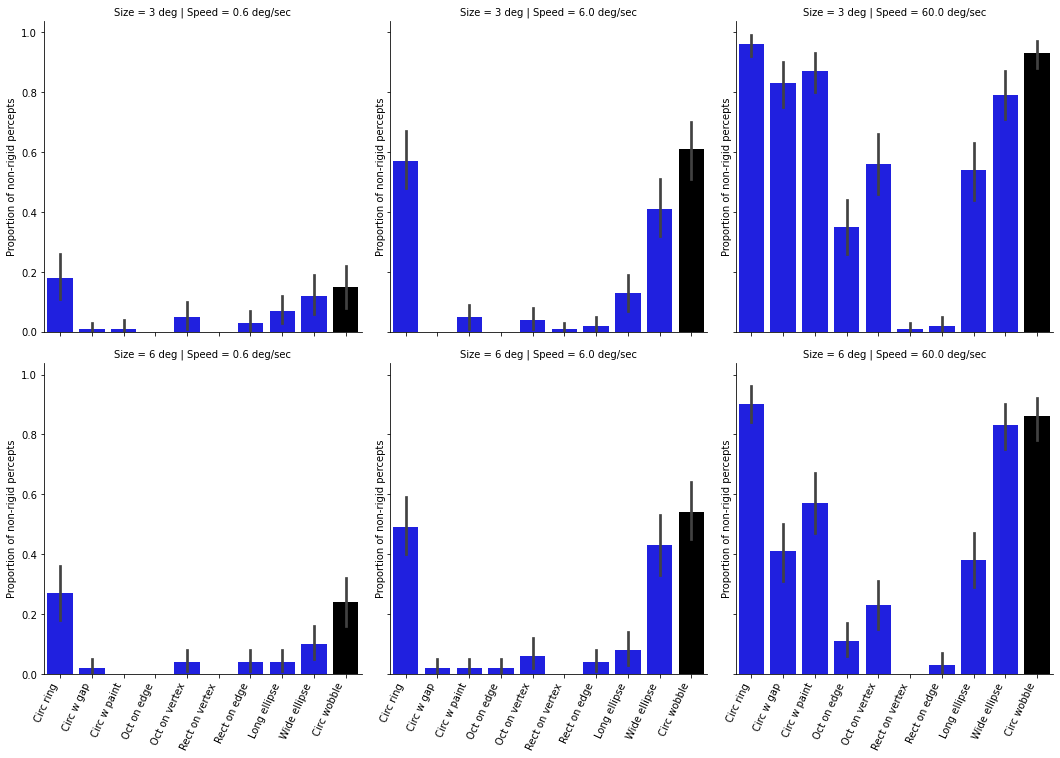

In [207]:
# Plot that 
sns_plot=sns.catplot(data=Result_all,x='Type',y= 'Response',row='Size',col='Speed',kind='bar',
                     row_order=['3 deg','6 deg'],col_order=['0.6 deg/sec','6.0 deg/sec','60.0 deg/sec'],
                     order=['Circ ring','Circ w gap','Circ w paint','Oct on edge','Oct on vertex',
                            'Rect on vertex','Rect on edge','Long ellipse','Wide ellipse',
                            'Circ wobble'],palette=sns.color_palette(['blue', 'blue','blue'
                                                                      ,'blue','blue','blue','blue','blue',
                                                                      'blue','black']))
sns_plot.set_xticklabels(rotation=65, horizontalalignment='right')
sns_plot.set(xlabel=None)
sns_plot.set(ylabel='Proportion of non-rigid percepts')

In [217]:
# I can use pivot the aggregated data to reshape in a way that it is easy 
# to compare the effect of speed/size
# pivot it by size
Agg_result.pivot_table(index=['Type','Speed'],columns=['Size'],values='Response')
# It seems like there is not much difference between two sizes

Size                         3 deg  6 deg
Type           Speed                     
Circ ring      0.6 deg/sec    0.18   0.27
               6.0 deg/sec    0.57   0.49
               60.0 deg/sec   0.96   0.90
Circ w gap     0.6 deg/sec    0.01   0.02
               6.0 deg/sec    0.00   0.02
               60.0 deg/sec   0.83   0.41
Circ w paint   0.6 deg/sec    0.01   0.00
               6.0 deg/sec    0.05   0.02
               60.0 deg/sec   0.87   0.57
Circ wobble    0.6 deg/sec    0.15   0.24
               6.0 deg/sec    0.61   0.54
               60.0 deg/sec   0.93   0.86
Long ellipse   0.6 deg/sec    0.07   0.04
               6.0 deg/sec    0.13   0.08
               60.0 deg/sec   0.54   0.38
Oct on edge    0.6 deg/sec    0.00   0.00
               6.0 deg/sec    0.00   0.02
               60.0 deg/sec   0.35   0.11
Oct on vertex  0.6 deg/sec    0.05   0.04
               6.0 deg/sec    0.04   0.06
               60.0 deg/sec   0.56   0.23
Rect on edge   0.6 deg/sec    0.03   0.04
               6.0 deg/sec    0.02   0.04
               60.0 deg/sec   0.02   0.03
Rect on vertex 0.6 deg/sec    0.00   0.00
               6.0 deg/sec    0.01   0.00
               60.0 deg/sec   0.01   0.00
Wide ellipse   0.6 deg/sec    0.12   0.10
               6.0 deg/sec    0.41   0.43
               60.0 deg/sec   0.79   0.83

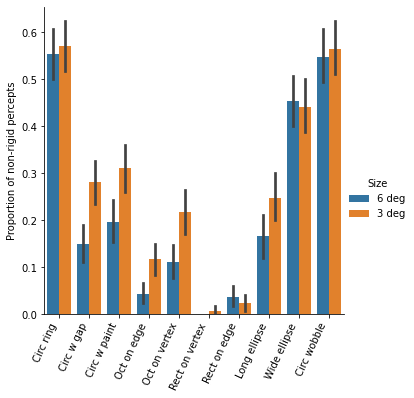

In [218]:
# Visualize it 
sns_plot=sns.catplot(data=Result_all,x='Type',y= 'Response',hue='Size',kind='bar',
                     order=['Circ ring','Circ w gap','Circ w paint','Oct on edge','Oct on vertex',
                            'Rect on vertex','Rect on edge','Long ellipse','Wide ellipse',
                            'Circ wobble'])
sns_plot.set_xticklabels(rotation=65, horizontalalignment='right')
sns_plot.set(xlabel=None)
sns_plot.set(ylabel='Proportion of non-rigid percepts')

In [222]:
# Let's see the effect of speed
Agg_result.pivot_table(index=['Type','Size'],columns=['Speed'],values='Response').reset_index()
# Regardless of the shape (except for rectangle) and the size, there are huge jump from
# low speed to high speed



Speed,Type,Size,0.6 deg/sec,6.0 deg/sec,60.0 deg/sec
0,Circ ring,3 deg,0.18,0.57,0.96
1,Circ ring,6 deg,0.27,0.49,0.90
2,Circ w gap,3 deg,0.01,0.00,0.83
3,Circ w gap,6 deg,0.02,0.02,0.41
4,Circ w paint,3 deg,0.01,0.05,0.87
5,Circ w paint,6 deg,0.00,0.02,0.57
6,Circ wobble,3 deg,0.15,0.61,0.93
7,Circ wobble,6 deg,0.24,0.54,0.86
8,Long ellipse,3 deg,0.07,0.13,0.54
9,Long ellipse,6 deg,0.04,0.08,0.38


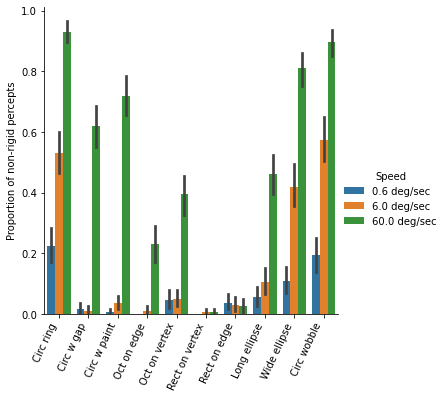

In [220]:
sns_plot=sns.catplot(data=Result_all,x='Type',y= 'Response',hue='Speed',kind='bar',
                     order=['Circ ring','Circ w gap','Circ w paint','Oct on edge','Oct on vertex',
                            'Rect on vertex','Rect on edge','Long ellipse','Wide ellipse',
                            'Circ wobble'],hue_order=['0.6 deg/sec','6.0 deg/sec','60.0 deg/sec'])
sns_plot.set_xticklabels(rotation=65, horizontalalignment='right')
sns_plot.set(xlabel=None)
sns_plot.set(ylabel='Proportion of non-rigid percepts')

In [234]:
# Make a wide data to practice "melt"
wide_data=Agg_result.pivot_table(index=['Type','Size'],columns=['Speed'],values='Response').reset_index()
wide_data



Speed,Type,Size,0.6 deg/sec,6.0 deg/sec,60.0 deg/sec
0,Circ ring,3 deg,0.18,0.57,0.96
1,Circ ring,6 deg,0.27,0.49,0.90
2,Circ w gap,3 deg,0.01,0.00,0.83
3,Circ w gap,6 deg,0.02,0.02,0.41
4,Circ w paint,3 deg,0.01,0.05,0.87
5,Circ w paint,6 deg,0.00,0.02,0.57
6,Circ wobble,3 deg,0.15,0.61,0.93
7,Circ wobble,6 deg,0.24,0.54,0.86
8,Long ellipse,3 deg,0.07,0.13,0.54
9,Long ellipse,6 deg,0.04,0.08,0.38


In [237]:
pd.melt(wide_data,id_vars=['Type','Size'],value_vars = ['0.6 deg/sec', '6.0 deg/sec', '60.0 deg/sec'], 
                       var_name = 'Speed', 
                       value_name='Total')

,Type,Size,Airport,Total
0,Circ ring,3 deg,0.6 deg/sec,0.18
1,Circ ring,6 deg,0.6 deg/sec,0.27
2,Circ w gap,3 deg,0.6 deg/sec,0.01
3,Circ w gap,6 deg,0.6 deg/sec,0.02
4,Circ w paint,3 deg,0.6 deg/sec,0.01
5,Circ w paint,6 deg,0.6 deg/sec,0.00
6,Circ wobble,3 deg,0.6 deg/sec,0.15
7,Circ wobble,6 deg,0.6 deg/sec,0.24
8,Long ellipse,3 deg,0.6 deg/sec,0.07
9,Long ellipse,6 deg,0.6 deg/sec,0.04
